#### catatan: 
beberapa data taksonomi memang kosong dari NCBInya, misal data interaksi virus pycv malah terhubung ke genus capsicum bukan spesies capsicum. dan itu memang dari data GloBInya langsung

In [21]:
# # reset import package
# def reloadPackageOwn():
#     from importlib import reload  
#     import os # we use os.path.join, os.path.basename
#     import sys # we use sys.path
#     import glob # we use glob.glob
#     import importlib # we use importlib.import_module

#     import_folder = os.getcwd()
#     sys.path.append(import_folder) # this tells python to look in `import_folder` for imports
#     for src_file in glob.glob(os.path.join(import_folder, '*.py')):
#         name = os.path.basename(src_file)[:-3]
#         importlib.import_module(name)
#         reload(sys.modules[name])
#         importlib.import_module(name)
        
# reloadPackageOwn()

In [22]:
from tqdm import tqdm
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG, Vertex
from pyrdf2vec.embedders import FastText,Word2Vec
from pyrdf2vec.walkers import RandomWalker
from pyvis.network import Network
from sklearn.manifold import TSNE
from umap import UMAP
from SPARQLWrapper import SPARQLWrapper
from jcopml.plot import plot_missing_value

import plotly.express as px
import pandas as pd
import numpy as np
import requests
import os
import networkx as nx
import matplotlib.pyplot as plt

from modul.vectorReferenced import get_taxon_vector,cek_ncbi_id_by_wiki_id_via_string
from modul.filterNodeEdge import removeNodeAndEdgeByFilter,removeEdgesNotInNodes
from modul.helper_umum import contains_string_entire_column,contains_string_entire_column_boolean
#from process import cek_bfs, nx_to_pyviz

#### Parameter

In [23]:
data=[
    ('1cucu','Cucumber mosaic virus','Aphididae','Myzus persicae'),
    ('2cri','Tomato chlorosis virus','Aleyrodidae','Bemisia Tabaci'),
    ('3wai','Maize chlorotic dwarf virus','Cicadellidae','Graminella nigrifrons'),
    ('4beg','Tomato yellow leaf curl China virus','Aleyrodidae','Bemisia Tabaci'),
    ('5pol','Cereal yellow dwarf virus','Aphididae','Schizaphis graminum'),
    ('6pea','Pea enation mosaic virus 1','Aphididae','Acyrthosiphon pisum'),
    ('7cucur','Cucurbit yellow stunting disorder virus','Aleyrodidae','Bemisia Tabaci'),
    ('8ten','Rice stripe tenuivirus','Delphacidae','Laodelphax striatellus'),
    ('9fiji','Southern rice black-streaked dwarf virus','Delphacidae','Sogatella furcifera'),
    ('10capchlo','Capsicum chlorosis orthotospovirus','Thripidae','Thrips Palmi'),
    ('11barley','Barley yellow dwarf virus GAV','Aphididae','Sitobion avenae'),
    ('12tospot','Tomato spotted wilt orthotospovirus','Thripidae','Frankliniella occidentalis'),
    # error dibawah ini
    # ('+13Poty','Potyvirus','Aphididae','Myzus'),
    # ('+11tung','Tungrovirus','Nilaparvata','Nilaparvata'),
]

data_,nama_virus,acuan_,ujian_=data[4] # vektor acuan  #data virus
bobot_ed=1;
bobot_dc=1;

In [24]:
# link enpoint sparql ncbi_ontology
ncbi_ontology_url = 'http://localhost:3030/mydataset/query'

#### input data

In [25]:
#1
#baca data
df_node=pd.read_csv('dari_praproses/'+data_+'_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/'+data_+'_edge.csv',index_col=0)

In [26]:
acuan_

'Aphididae'

In [27]:
# pra-proses khusus proses
# hapus serangga yg cuma famili mengikuti acuan. soalnya klo cuma tampil famili apa gunanya?
filter_genus_sampai_species_null=(
    (df_node.genus.isnull()) &
    (df_node.species.isnull()) &
    (df_node['class']=='NCBI:50557_Insecta')
)
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[filter_genus_sampai_species_null], df_node,df_edge)

In [28]:
# pra-proses khusus proses
#isi data kosong. mengisi takson kosong, dengan takson sebelumnya, untuk tambalan
takson=[
    'superkingdom','kingdom','phylum','class','order','family','genus','species'
]

for x,i in enumerate(takson):
    if (i!='superkingdom'): #selain superkingdom update dengan data sebelumnya
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x-1]]+'^'+i
    else: 
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x+1]]+'^'+i

In [29]:
# pra-proses khusus proses
# eksperimen tambahan. bikin fakta tambahan, yaitu relasi virus utama dengan acuan 
virus_utama=df_node[df_node.virus_utama==True].taxon_id.to_list()
serangga_acuan=contains_string_entire_column(df_node,acuan_).taxon_id.to_list()

for i in virus_utama:
    for j in serangga_acuan:
        df_edge.loc[len(df_edge),['source_taxon_id','target_taxon_id','interaction_type']] = [i,j,'pathogenOf']

In [30]:
if(len(df_node[df_node['group']=="serangga"])<=2):
    print("cuma dua serangga")

#### Konversi graf

In [31]:
#3
#konversi graph 
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

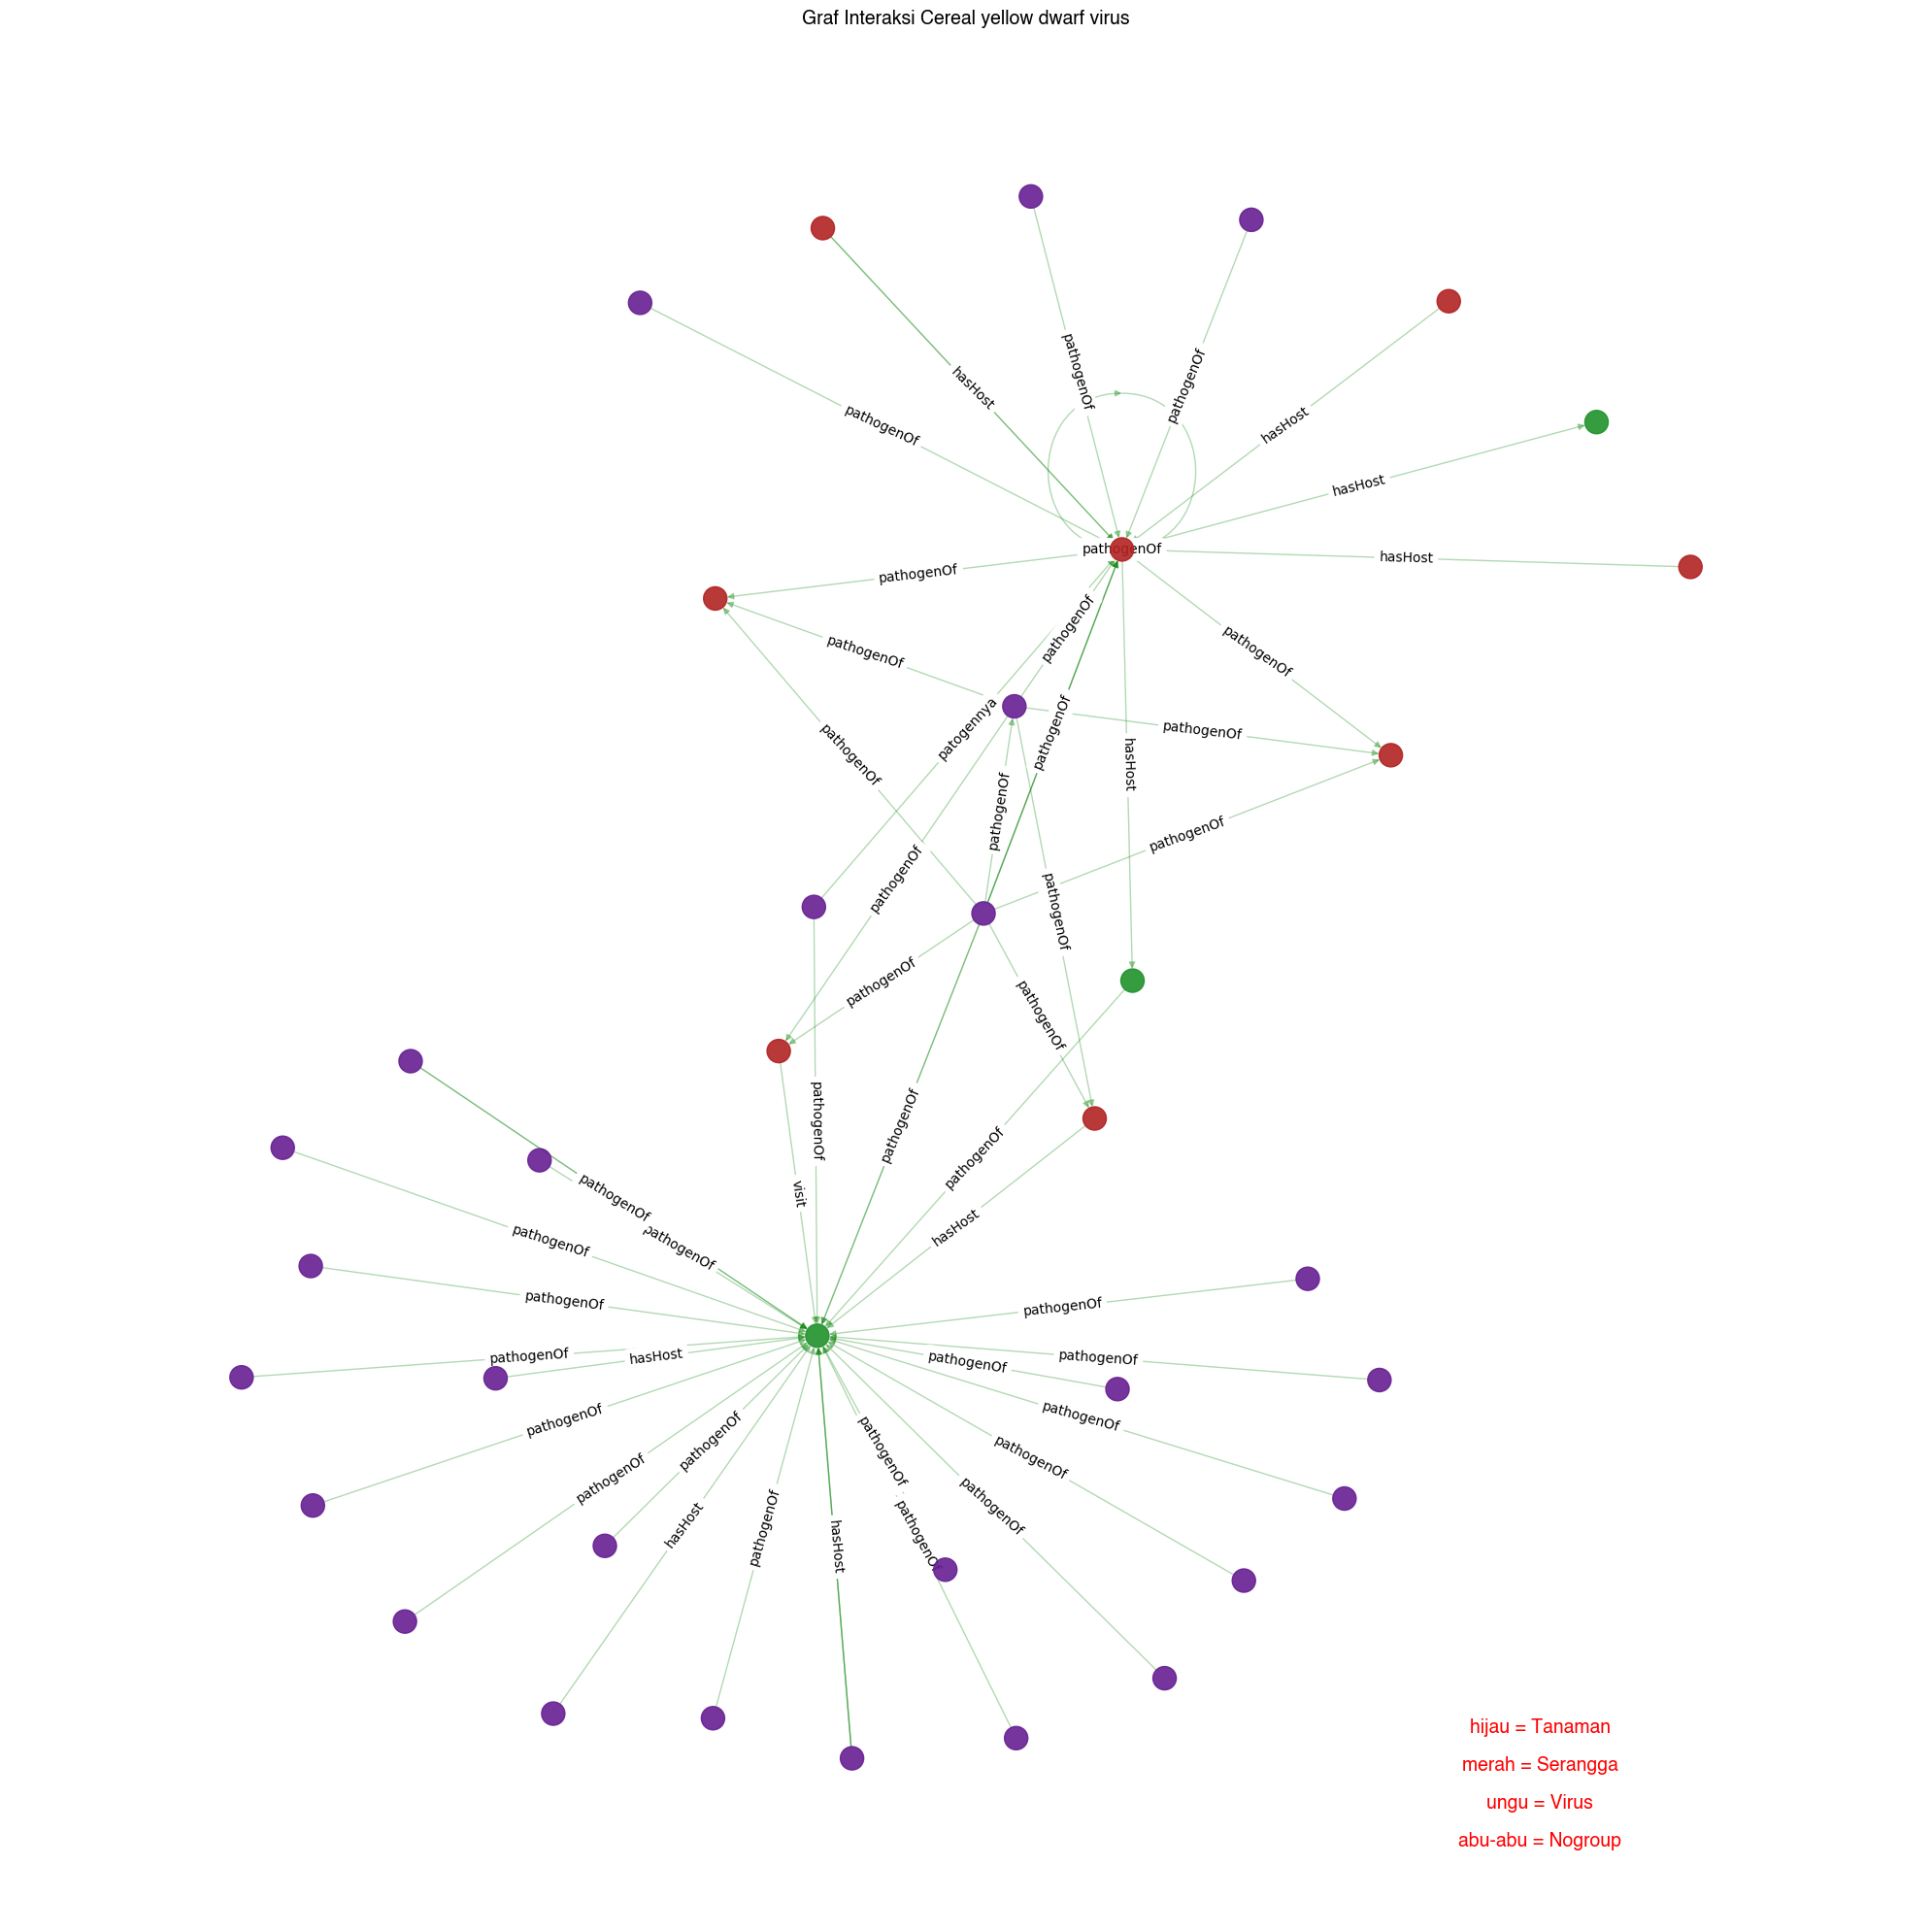

In [32]:
# cuma tampilan, visualisasi graf
G=gnx

fig, ax = plt.subplots(figsize=(20, 20))

# Generate layout for visualization
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G, "color").values()), alpha=0.9)

#node label
# for i in ['#b22222','#671f92','#1f922b','#EADDCA']: # filtering dengan bedakan warna node
#     label_options = {"ec": i, "fc": 'white', "alpha": 0.7}
#     nx.draw_networkx_labels(
#         nx.subgraph_view(G, filter_node=lambda n1: G.nodes(data=True)[n1].get("color", True) == i),
#         pos, 
#         font_size=10, 
#         bbox=label_options
#     )

#edge labels
edge_labels={x:i for i,x in zip(nx.get_edge_attributes(G, "label").values(),G.edges())}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Graf Interaksi "+nama_virus, font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "hijau = Tanaman",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.08,
    "merah = Serangga",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.06,
    "ungu = Virus",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.04,
    "abu-abu = Nogroup",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

In [33]:
# # cuma tampilan, visualisasi pyviz
from pyvis.network import Network
nt = Network('500px', '900px',directed=True,notebook=True)
# nt.show_buttons(filter_=['physics'])
nt.toggle_physics(True)

for i,data in gnx.nodes(data=True):
    nt.add_node(
        i,
        label= data['label'],
        superkingdom= data['superkingdom'],
        kingdom= data['kingdom'],
        filum= data['filum'],
        kelas= data['kelas'],
        ordo= data['ordo'],
        famili= data['famili'],
        genus= data['genus'],
        spesies= data['spesies'],
        group= data['group'],
        color= data['color'],
        )
    
for s,t,data in gnx.edges(data=True):
    nt.add_edge(
        s,
        t,
        label=data['label'])

nt.show("tmp.fig02.html")

In [34]:
#4 
# Degree Centrality
results = nx.degree_centrality(gnx)
allnodes = gnx.nodes

In [35]:
# TAMBAHAN UNTUK CEK KUALITAS RELASI SERANGGA
def bfs_relasi_ke_virus_utama(gnx, to_search, virus_utama_ids):
    counter=0
    for edge in nx.bfs_edges(gnx.to_undirected(), source=to_search, depth_limit=2):
        s_id, o_id = edge

        s_label = gnx.nodes[s_id]['label'] +' '+s_id
        o_label = gnx.nodes[o_id]['label'] +' '+o_id

        # skip subjek to_search
        if (s_id == to_search) & (o_id in virus_utama_ids):
            print(s_label,'-->', o_label)
            counter+=1
    
    return counter

# tandai virus utama, sudah di praproses
# search_virus,taxon_,ncbi_id_=cek_ncbi_id_by_wiki_id_via_string(virus_utama)
# print("keyword virus utama: ",(search_virus,taxon_,ncbi_id_))
# df_node.loc[df_node[taxon_].str.contains(search_virus), ['virus_utama']] = True

# hitung relasi ke virus utama setiap serangga
virus_utama_ids=list(df_node[df_node['virus_utama']==True].taxon_id)
for idx,data in df_node[(df_node['group']=='serangga')].iterrows():
    _relasi = bfs_relasi_ke_virus_utama(gnx,data.taxon_id,virus_utama_ids)
    if(_relasi>0):
        print(idx,data.taxon_name,data.taxon_id)
        print(_relasi)
    df_node.loc[idx,'relasi_ke_virus_utama'] = _relasi
    # print("=================")
    # update DC pake bobot
    # reset_n=(len(gnx.nodes)-1)/(len([node for node, data in gnx.nodes(data=True) if data.get('group') == "serangga"])-1)
    # results[data.taxon_id] = 1+(results[data.taxon_id]*_relasi*reset_n) #1+(CM*w) #kalo pake jumlah serangga sebagai pembagi
    results[data.taxon_id] = 1+(results[data.taxon_id]*_relasi) #1+(CM*w)

Metopolophium dirhodum NCBI:44670 --> Cereal yellow dwarf virus RPV NCBI:2170100
Metopolophium dirhodum NCBI:44670 --> Cereal yellow dwarf virus-RPV satellite RNA NCBI:191032
133 Metopolophium dirhodum NCBI:44670
2
Sitobion avenae NCBI:44664 --> Cereal yellow dwarf virus RPV NCBI:2170100
Sitobion avenae NCBI:44664 --> Cereal yellow dwarf virus-RPV satellite RNA NCBI:191032
141 Sitobion avenae NCBI:44664
2
Rhopalosiphum padi NCBI:40932 --> Cereal yellow dwarf virus RPV NCBI:2170100
Rhopalosiphum padi NCBI:40932 --> Cereal yellow dwarf virus-RPV satellite RNA NCBI:191032
146 Rhopalosiphum padi NCBI:40932
2
Schizaphis graminum NCBI:13262 --> Cereal yellow dwarf virus RPV NCBI:2170100
Schizaphis graminum NCBI:13262 --> Cereal yellow dwarf virus-RPV satellite RNA NCBI:191032
147 Schizaphis graminum NCBI:13262
2
Rhopalosiphum rufiabdominalis NCBI:273650 --> Cereal yellow dwarf virus RPV NCBI:2170100
Rhopalosiphum rufiabdominalis NCBI:273650 --> Cereal yellow dwarf virus-RPV satellite RNA NCB

In [36]:
dc_serangga=[]
for node_id, rank in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if allnodes[node_id]['group'] in ['serangga']:
        label = gnx.nodes[node_id]['label']
        dc_serangga.append((rank, label, node_id))

In [37]:
dc_serangga

[(2.0, 'Rhopalosiphum padi', 'NCBI:40932'),
 (1.1666666666666667, 'Metopolophium dirhodum', 'NCBI:44670'),
 (1.1666666666666667, 'Sitobion avenae', 'NCBI:44664'),
 (1.1666666666666667, 'Schizaphis graminum', 'NCBI:13262'),
 (1.1666666666666667, 'Rhopalosiphum rufiabdominalis', 'NCBI:273650'),
 (1.0, 'Aphelinus mali', 'NCBI:163151'),
 (1.0, 'Aphidius rhopalosiphi', 'NCBI:55891'),
 (1.0, 'Aphelinus varipes', 'NCBI:163155')]

In [38]:
#visualisasi data
# mengecek BFS Degree tertinggi
for to_search  in [dc_serangga[0][2]]:#["NCBI:7038"]:#"NCBI:33377","NCBI:7036",
    for edge in nx.bfs_edges(gnx.to_undirected(), source=to_search, depth_limit=1):
            s_id, o_id = edge

            s_label = gnx.nodes[s_id]['label'] +' '+s_id
            o_label = gnx.nodes[o_id]['label'] +' '+o_id
            o_grup = gnx.nodes[o_id]['group']

            # skip subjek to_search
            if (o_grup == 'virus'):
                print(s_label,'-->', o_label)
    print('===============')

Rhopalosiphum padi NCBI:40932 --> Cereal yellow dwarf virus RPV NCBI:2170100
Rhopalosiphum padi NCBI:40932 --> Cereal yellow dwarf virus-RPV satellite RNA NCBI:191032
Rhopalosiphum padi NCBI:40932 --> Rhopalosiphum padi virus NCBI:66834
Rhopalosiphum padi NCBI:40932 --> Cereal yellow dwarf virus RPS NCBI:228582
Rhopalosiphum padi NCBI:40932 --> Aphid lethal paralysis virus NCBI:209529
Rhopalosiphum padi NCBI:40932 --> Potyvirus NCBI:39729


In [39]:
for i in [dc_serangga[0][2]]:#["NCBI:33377","NCBI:7036","NCBI:7038","NCBI:65032"]:
    print(gnx.nodes[i])

{'label': 'Rhopalosiphum padi', 'superkingdom': 'NCBI:2759_Eukaryota', 'kingdom': 'NCBI:33208_Metazoa', 'filum': 'NCBI:6656_Arthropoda', 'kelas': 'NCBI:50557_Insecta', 'ordo': 'NCBI:7524_Hemiptera', 'famili': 'NCBI:27482_Aphididae', 'genus': 'NCBI:40931_Rhopalosiphum', 'spesies': 'NCBI:40932_Rhopalosiphum padi', 'group': 'serangga', 'color': '#b22222'}


In [40]:
#5
# Ambil data NCBI
# data acuan
data_acuan=get_taxon_vector(acuan_,ncbi_ontology_url)
print(data_acuan)
data_ujian=get_taxon_vector(ujian_,ncbi_ontology_url)
print(data_ujian)

[('famili', 'NCBI:27482_Aphididae'), ('ordo', 'NCBI:7524_Hemiptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]
[('spesies', 'NCBI:13262_Schizaphis graminum'), ('genus', 'NCBI:13261_Schizaphis'), ('famili', 'NCBI:27482_Aphididae'), ('ordo', 'NCBI:7524_Hemiptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]


In [41]:
#6
#konversi node networkx ke RDF
URL = "http://pyRDF2Vec"
CUSTOM_KG = KG()

takson=[i[0] for i in data_acuan]
for i in ["superkingdom","kingdom","filum","kelas"]:
    takson.remove(i) 

# memasukan RDF serangga acuan
subj = Vertex(f"{URL}#SERANGGA_ACUAN")
for i,j in data_acuan:
    if(i not in ["superkingdom","kingdom","filum","kelas"]):
        j = j.replace(' ','-')
        obj = Vertex((URL+"#"+j))
        pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
        #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
        CUSTOM_KG.add_walk(subj, pred, obj)

# proses konversi 
for index,data in gnx.nodes(data=True):
    if(data['group']=='serangga'): #jika serangga
        subj = Vertex(URL+"#"+index)
        for i in takson:
            #if(isinstance(data[i], str)): #jika dia string atau tidak nan/kosong.
            #if(i not in ["superkingdom","kingdom","filum","kelas"]):
                id_takson=data[i].replace(' ','-')#.split('_')[0]
                obj = Vertex((URL+"#"+id_takson))
                pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
                #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
                CUSTOM_KG.add_walk(subj, pred, obj)
# CUSTOM_KG.literals=[
#         [f"{URL}#taxon_path_ids"],
#     ]
CUSTOM_KG.literals = [[URL+"#"+i] for i in takson]

In [42]:
#7
#embedding
# Ensure the determinism of this script by initializing a pseudo-random number.
RANDOM_STATE = 22
transformer = RDF2VecTransformer(
    # Use one worker threads for Word2Vec to ensure random determinism.
    # Must be used with PYTHONHASHSEED.
    Word2Vec(epochs=1000),
    # Extract a maximum of 10 walks of a maximum depth of 4 for each entity
    # using two processes and use a random state to ensure that the same walks
    # are generated for the entities.
    walkers=[RandomWalker(2, 5, n_jobs=2, with_reverse=False, random_state=RANDOM_STATE)],
    #verbose=1,
)
# transformer = RDF2VecTransformer(verbose=1)
# list entity yang akan diembedd. serangga acuan urutan terakhir
ent = [ URL+"#"+index for index,data in gnx.nodes(data=True) if(data['group']=='serangga') ] #jika serangga
ent.append(f"{URL}#SERANGGA_ACUAN")
# Fit the transformer to the knowledge graph and the entities.
embeddings, _ = transformer.fit_transform(
    CUSTOM_KG, #the KG
    ent, #entity
)

In [43]:
# visualisasi

# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X= UMAP().fit_transform(embeddings)
df_umap=pd.DataFrame(X,columns=['feature-vector-1','feature-vector-2'])


text=[]
labels=[]
for x in transformer._entities:
    if(x!="http://pyRDF2Vec#SERANGGA_ACUAN"):
        text.append(gnx.nodes[x.split("#")[-1]]['famili'].split('_')[-1])
        labels.append(gnx.nodes[x.split("#")[-1]]['label'])
    else:
        text.append("#TITIK_VEKTOR_ACUAN")
        labels.append("#TITIK_VEKTOR_ACUAN")
df_umap['text']=text
df_umap['labels']=labels

# # gnx.nodes[x.split("#")[-1]]['label']
# df_umap['text']=list(map(lambda x: x.split("#")[-1],transformer._entities))
fig = px.scatter(df_umap, x='feature-vector-1',y='feature-vector-2',text='text',hover_name='labels')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=650,
    title_text='reduced word2vec visualization'
)
fig.show()

/Users/mohzulkiflikatili/miniconda3/envs/thesis/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [44]:
#8
#euclidean distance

# buat dataframe
data_to_count=pd.DataFrame(embeddings, columns=list(range(0,100)))

# buat kolom label
ent=[data['label'] for index,data in gnx.nodes(data=True) if(data['group']=='serangga')] #jika serangga
ent.append("#SERANGGA_ACUAN")
data_to_count['label']=ent

#buat kolom entity
data_to_count['entity']=[i.replace("http://pyRDF2Vec#","") for i in transformer._entities]

# buat kolom hasil dc
for idx,row in data_to_count.iterrows(): #jika serangga acuan maka DC di isi nilai 1
    data_to_count.loc[idx,['dc_result']] = results[row['entity']] if(row['entity']!="SERANGGA_ACUAN") else 1

#ambil koordinat acuan
acuan=next(data_to_count[data_to_count['label']=='#SERANGGA_ACUAN'].iterrows())[1]
acuan=np.array(tuple(acuan[i] for i in range(0,100)))
acuan

#hitung ED
for idx, row in data_to_count.iterrows():
    temp = np.array(tuple(row[i] for i in range(0,100)))
    data_to_count.loc[idx,['ed_result']] = np.linalg.norm(temp - acuan)

#drop data acuan
data_to_count.drop(data_to_count[data_to_count.label=="#SERANGGA_ACUAN"].index,inplace=True)

In [45]:
#drop kolom embedding
data_to_count.drop(columns=list(range(0,100)), inplace=True)

In [46]:
# minmax scaling dc dan ed
# for i in ['dc_result', 'ed_result']:
#     pembagi = data_to_count[i].max() - data_to_count[i].min()
#     pembilang = data_to_count[i] - data_to_count[i].min()
#     data_to_count[i] = pembilang / pembagi


# simple scaling
for i in ['dc_result', 'ed_result']:
    data_to_count[i] = data_to_count[i] / data_to_count[i].max()

In [47]:
#9
#hitung kombinasi
for idx, row in data_to_count.iterrows():
    _dc = row['dc_result']
    _ed=( (row['ed_result']) if row['ed_result']!=0 else 1)
    data_to_count.loc[idx,['result']] = _dc/_ed

# simple scaling result
data_to_count['result'] = data_to_count['result'] / data_to_count['result'].max()

In [48]:
# DC
data_to_count=data_to_count.sort_values('dc_result',ascending=False).reset_index(drop=True)
data_to_count[['label','entity','dc_result']]

,label,entity,dc_result
0,Rhopalosiphum padi,NCBI:40932,1.000000
1,Metopolophium dirhodum,NCBI:44670,0.583333
2,Sitobion avenae,NCBI:44664,0.583333
3,Schizaphis graminum,NCBI:13262,0.583333
4,Rhopalosiphum rufiabdominalis,NCBI:273650,0.583333
5,Aphelinus mali,NCBI:163151,0.500000
6,Aphidius rhopalosiphi,NCBI:55891,0.500000
7,Aphelinus varipes,NCBI:163155,0.500000


In [49]:

# Pengujian dc
for urutan in range(0,5):
    takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
    id_hasil=data_to_count.iloc[urutan].entity
    cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
    cek_ujian= { k:v for k,v in data_ujian if k in takson }
    # print(acuan_,'->', data_)
    # print('ujian ',cek_ujian)
    print('hasil ',cek_hasil)
    cek=0
    for i in reversed(takson):
        cekk=cek_hasil[i]==cek_ujian[i]
        cek+=cekk
        # print(i, cekk)
    print(cek/len(takson))

hasil  {'spesies': 'NCBI:40932_Rhopalosiphum padi', 'genus': 'NCBI:40931_Rhopalosiphum', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:44670_Metopolophium dirhodum', 'genus': 'NCBI:44669_Metopolophium', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:44664_Sitobion avenae', 'genus': 'NCBI:44662_Sitobion', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:13262_Schizaphis graminum', 'genus': 'NCBI:13261_Schizaphis', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
1.0
hasil  {'spesies': 'NCBI:273650_Rhopalosiphum rufiabdominalis', 'genus': 'NCBI:40931_Rhopalosiphum', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5


In [50]:
# ED
data_to_count=data_to_count.sort_values('ed_result',ascending=True).reset_index(drop=True)
data_to_count[['label','entity','ed_result']]

,label,entity,ed_result
0,Metopolophium dirhodum,NCBI:44670,0.705792
1,Sitobion avenae,NCBI:44664,0.727760
2,Rhopalosiphum padi,NCBI:40932,0.785963
3,Rhopalosiphum rufiabdominalis,NCBI:273650,0.835104
4,Schizaphis graminum,NCBI:13262,0.876625
5,Aphelinus varipes,NCBI:163155,0.881314
6,Aphelinus mali,NCBI:163151,0.967706
7,Aphidius rhopalosiphi,NCBI:55891,1.000000


In [51]:
# Pengujian ed
for urutan in range(0,3):
    takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
    id_hasil=data_to_count.iloc[urutan].entity
    cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
    cek_ujian= { k:v for k,v in data_ujian if k in takson }
    # print(acuan_,'->', data_)
    # print('ujian ',cek_ujian)
    print('hasil ',cek_hasil)
    cek=0
    for i in reversed(takson):
        cekk=cek_hasil[i]==cek_ujian[i]
        cek+=cekk
        # print(i, cekk)
    print(cek/len(takson))

hasil  {'spesies': 'NCBI:44670_Metopolophium dirhodum', 'genus': 'NCBI:44669_Metopolophium', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:44664_Sitobion avenae', 'genus': 'NCBI:44662_Sitobion', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:40932_Rhopalosiphum padi', 'genus': 'NCBI:40931_Rhopalosiphum', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5


In [52]:
# final score kombinasi
data_to_count=data_to_count.sort_values('result',ascending=False).reset_index(drop=True)
data_to_count[['label','dc_result','ed_result','result']]

,label,dc_result,ed_result,result
0,Rhopalosiphum padi,1.000000,0.785963,1.000000
1,Metopolophium dirhodum,0.583333,0.705792,0.649594
2,Sitobion avenae,0.583333,0.727760,0.629986
3,Rhopalosiphum rufiabdominalis,0.583333,0.835104,0.549007
4,Schizaphis graminum,0.583333,0.876625,0.523004
5,Aphelinus varipes,0.500000,0.881314,0.445904
6,Aphelinus mali,0.500000,0.967706,0.406096
7,Aphidius rhopalosiphi,0.500000,1.000000,0.392981


In [53]:
# Pengujian kombinasi
for urutan in range(0,5):
    takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
    id_hasil=data_to_count.iloc[urutan].entity
    cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
    cek_ujian= { k:v for k,v in data_ujian if k in takson }
    # print(acuan_,'->', data_)
    # print('ujian ',cek_ujian)
    print('hasil ',cek_hasil)
    cek=0
    for i in reversed(takson):
        cekk=cek_hasil[i]==cek_ujian[i]
        cek+=cekk
        # print(i, cekk)
    print(cek/len(takson))

hasil  {'spesies': 'NCBI:40932_Rhopalosiphum padi', 'genus': 'NCBI:40931_Rhopalosiphum', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:44670_Metopolophium dirhodum', 'genus': 'NCBI:44669_Metopolophium', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:44664_Sitobion avenae', 'genus': 'NCBI:44662_Sitobion', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:273650_Rhopalosiphum rufiabdominalis', 'genus': 'NCBI:40931_Rhopalosiphum', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:13262_Schizaphis graminum', 'genus': 'NCBI:13261_Schizaphis', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
1.0


In [54]:
# Pengujian kombinasi
# cek=1
# takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
# urutan=0
# while cek/len(takson)>0:
#     id_hasil=data_to_count.iloc[urutan].entity
#     cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
#     cek_ujian= { k:v for k,v in data_ujian if k in takson }
#     # print(acuan_,'->', data_)
#     # print('ujian ',cek_ujian)
#     print('hasil ', urutan ,cek_hasil)
#     cek=0
#     for i in reversed(takson):
#         cekk=cek_hasil[i]==cek_ujian[i]
#         cek+=cekk
#         # print(i, cekk)
#     print(cek/len(takson))
#     urutan+=1

# Pengujian

In [55]:
# for urutan in 0,1,2:
#     takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
#     id_hasil=data_to_count.iloc[urutan].entity
#     cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
#     cek_ujian= { k:v for k,v in data_ujian if k in takson }
#     print(acuan_,'->', data_)
#     print('ujian ',cek_ujian)
#     print('hasil ',cek_hasil)
#     cek=0
#     for i in reversed(takson):
#         cekk=cek_hasil[i]==cek_ujian[i]
#         cek+=cekk
#         print(i, cekk)
#     print(cek/len(takson))

In [56]:
#visualisasi data
# mengecek BFS Degree tertinggi
for edge in nx.bfs_edges(gnx.to_undirected(), source="NCBI:3483", depth_limit=1):
        s_id, o_id = edge

        s_label = gnx.nodes[s_id]['label'] +' '+s_id
        o_label = gnx.nodes[o_id]['label'] +' '+o_id
        o_grup = gnx.nodes[o_id]['group']

        # skip subjek to_search

        print(s_label,'-->', o_label)
print('===============')

NetworkXError: The node NCBI:3483 is not in the graph.

In [ ]:
Myzus persicae NCBI:13164 --> Cannabis sativa NCBI:3483


SyntaxError: invalid syntax (2674548215.py, line 1)